# Forecasting the future incidence of highly pathogenic contagious diseases

In [1]:
import os
import time
from termcolor import colored
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from python.models import model_TCN
from python.transform import log_df, inv_log_df

%matplotlib inline

## Loading data

In [ ]:
# n_his is the number of days used for model input
n_his = 30
n_inf_days = 30
n_pred_days = 1

data_path = './dataset/train_data_all'
output_path = './dataset/data_processed'
city_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]

region_nums = []
for city in city_list:
    filename = os.path.join(data_path, f'city_{city}', 'grid_attr.csv')
    df = pd.read_csv(filename, header=None, names=['x', 'y', 'region'])
    region_nums.append(len(set(df['region'])))
tot_regions = sum(region_nums)
    
population_dict = (pd
                   .read_csv(os.path.join(output_path, 'density.csv'))[:6]
                   .drop(columns=['date'])
                   .mean(axis=0)
                   .to_dict())

df_inf = pd.read_csv(os.path.join(output_path, 'infection.csv'))
df_dens_int = pd.read_csv(os.path.join(output_path, 'density_int.csv'))
df_mig_in = pd.read_csv(os.path.join(output_path, 'migration_in.csv'))
df_mig_out = pd.read_csv(os.path.join(output_path, 'migration_out.csv'))

del df_inf['date']
del df_dens_int['date']
del df_mig_in['date']
del df_mig_out['date']

df_inf = df_inf.sort_index(axis=1)
cols = df_inf.columns.to_list()

df_dens_int = df_dens_int.sort_index(axis=1)
df_mig_in = df_mig_in.sort_index(axis=1)
df_mig_out = df_mig_out.sort_index(axis=1)

## Processing data

Calculate some new features

In [5]:
# dinsity (flux)
df_popu = df_dens_int.copy()
for col in df_popu.columns:
    df_popu[col] = population_dict[col]
    
# average migration
df_mig_avg = (df_mig_in + df_mig_out) / 2.

# cumulitive infection
df_cumu = df_inf.cumsum()

# inverse increasing rate = 1 / (cumu_inf_today / cumu_inf_yesterday)
# call it "decrease", but it's not the real decreasing rate
df_dcrs = (df_cumu.shift() / df_cumu).fillna(0)

Most data are transformed by taking log plus 1.

In [7]:
# transforming datasets and taking lags

df_inf, sc_inf, max_inf = log_df(df_inf)
df_inf_lag = df_inf.shift(periods=1)
df_inf_lag[:1] = 0

df_cumu, sc_cumu, max_cumu = log_df(df_cumu)
df_cumu_lag = df_cumu.shift(periods=1)
df_cumu_lag[:1] = 0

df_dcrs = df_dcrs.shift(periods=1)
df_dcrs[:1] = 0

df_popu, sc_popu, max_popu = log_df(df_popu)
df_mig_avg, sc_mig_avg, max_mig_avg = log_df(df_mig_avg)
df_dens_int, sc_dens_int, max_dens_int = log_df(df_dens_int)

In [10]:
df_feat_dict = {'inf_lag'       : df_inf_lag,
                'cumu_lag'      : df_cumu_lag, 
                'dcrs'          : df_dcrs,
                'popu'          : df_popu, 
                'mig_avg'        : df_mig_avg, 
                'dens'           : df_dens_int, 
               }

df_feat_list = list(df_feat_dict.values())
# append y to the list
list_df = df_feat_list + [df_inf]

## Data Formatting

In [11]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_his, n_pred=1):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_his
        out_end_ix = end_ix + n_pred - 1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def get_xy(list_df, col='A_10', n_his=10, n_pred=1):
    list_seq = []
    # loop over features
    for df in list_df:
        seq = df[col].values.reshape((len(df), 1))
        list_seq.append(seq)
    dataset = np.hstack(list_seq)
    X, y = split_sequences(dataset, n_his, n_pred)
    # city_region_day
    label = np.char.add(col+'_', np.arange(y.shape[0]).astype(str))
    return X, y, label

def get_xy_all(list_df, n_his=10, n_pred=1):
    X_list = []
    y_list = []
    label_list = []
    for col in cols:
        X, y, label = get_xy(list_df, col=col, n_his=n_his, n_pred=n_pred)
        X_list.append(X)
        y_list.append(y)
        label_list.append(label)
    X = np.vstack(X_list)
    y = np.vstack(y_list)
    label = np.hstack(label_list)
    return X, y, label

def get_xy_inf(list_df, n_his=10, n_pred=1):
    X_list = []
    y_list = []
    label_list = []
    for col in cols:
        X, y, label = get_xy(list_df, col=col, n_his=n_his, n_pred=1)
        X_list.append(X[-1:])
        y_list.append(y[-1:])
        label_list.append(label[-1:])
    X = np.vstack(X_list)
    y = np.vstack(y_list)
    label = np.hstack(label_list)
    return X, y, label

## Inference

In [50]:
# take the contral value over last 10 values for inference
mig_avg_last = df_mig_avg[-10:].median(axis=0).values
dens_int_last = df_dens_int[-10:].median(axis=0).values
        
# linear fit
class Fitter():
    def __init__(self):
        self.n_data_fit = 20 # number of data used for fitting
        self.active = False # if fitter is triggered
        self.n_preds = 0 # prediciont counter
        self.coef = np.array([99,99]) # (slope, intercept)
        self.poly1d_fn = None # fitting function

    def reset(self):
        self.active = False
        self.n_preds = 0
        self.coef = np.array([99,99])
        self.poly1d_fn = None

    def passed_peak(self, a_in):
        # fitting might be unstable if there's a lot of missing data
        has_data = sum(a_in>0) > self.n_data_fit
        max_idx = a_in.argmax()
        # the peak should be in front of fitting data
        return max_idx < (len(a_in) - self.n_data_fit)

    def predict(self, a_in):
        # a_in non-transformed
        if a_in[-1] < 1:
            return 0 # infection number should be an integer

        if not self.active:
            if not self.passed_peak(a_in):
                return -99

            x = np.arange(self.n_data_fit)
            y = a_in[-self.n_data_fit:]
            mask = y>0
            x = x[mask]
            y = np.log(y[mask]) # assume non-transformed

            coef = np.polyfit(x, y, 1)
            if (coef[0]>=0):
                return -99
            elif (coef[0]<=self.coef[0]):
                self.coef = coef
                return -99
            else:
                # trigger of the linear fit
                self.active = True
                self.poly1d_fn = np.poly1d(self.coef) 

        pred = self.poly1d_fn(self.n_data_fit+self.n_preds)
        self.n_preds += 1 # increase by 1 after each prediction

        # transform back to original infection
        pred = np.exp(pred)
        return pred        

In [47]:
pred_cols = list(df_feat_dict.keys())

id_IL = pred_cols.index('inf_lag') if 'inf_lag' in pred_cols else -99
id_CML = pred_cols.index('cumu_lag') if 'cumu_lag' in pred_cols else -99
id_DC = pred_cols.index('dcrs') if 'dcrs' in pred_cols else -99
id_PP = pred_cols.index('popu') if 'popu' in pred_cols else -99
id_MA = pred_cols.index('mig_avg') if 'mig_avg' in pred_cols else -99
id_DENS = pred_cols.index('dens') if 'dens' in pred_cols else -99


def inference(X_in, y_in, n_pred, model_list, int_inf=True, linear_fit=False):
    single_model = len(model_list)==1
    # X = (n_region, n_his, n_feat)
    X = X_in.copy()
    pred_size = len(X)
    batch_size = 1
    while batch_size < pred_size:
        batch_size = batch_size * 2
    
    pred_list = []
    fitters = [Fitter() for i in range(tot_regions)]
    for i in range(n_pred):
        # pred = (n_region,) 
        if i==0:
            pred = y_in.reshape((-1,1))
        else:
            # prediction from all models
            preds = []
            for model in model_list:
                pred = model.predict(X, verbose=0, batch_size=1000)[:,0,:].reshape((-1,1))
                pred[pred < 0] = 0
                preds.append(pred)
            # use the central model
            pred = preds[0] if single_model else np.median(preds, axis=0)
        
        # feat_new = (n_region, n_feat) 
        feat_new = np.zeros(shape=X[:,-1,:].shape)
        
        ##### new infection #####
        if id_IL >= 0:
            feat_new[:, id_IL] = pred[:, -1].copy()
            inf_today = inv_log_df(feat_new[:, id_IL], sc_inf, max_inf)
            if linear_fit and i>0:
                inf_his = inv_log_df(X[:,:,id_IL], sc_inf, max_inf)
                inf_linear = np.array([fitters[i].predict(inf_his[i,:]) for i in range(tot_regions)])
                # linear fit is done for log scale, so inf_linear must be >= 0
                _mask = inf_linear >= 0
                inf_today[_mask] = inf_linear[_mask]
            if int_inf and i>0:
                inf_today = inf_today.astype(int)
            feat_new[:, id_IL], _, _ = log_df(inf_today, sc_inf, max_inf)
            if i>0:
                inf_last = inv_log_df(X[:, -1, id_IL], sc_inf, max_inf)
                feat_new[:, id_IL][inf_last<1] = 0
        ##### cumulative #####
        if id_CML >= 0:
            cumu_last = inv_log_df(X[:, -1, id_CML], sc_cumu, max_cumu)
            inf_today = inv_log_df(feat_new[:, id_IL], sc_inf, max_inf)
            cumu_today = cumu_last + inf_today
            feat_new[:, id_CML], _, _ = log_df(cumu_today, sc_cumu, max_cumu)
        ##### inversed increasing rate #####
        if id_DC >= 0:
            dcrs_rate = cumu_last / np.where(cumu_today==0, np.inf, cumu_today)
            feat_new[:, id_DC] = dcrs_rate
        ##### migration #####
        if id_MA >= 0:
            feat_new[:, id_MA] = mig_avg_last    
        ##### density #####
        if id_DENS >= 0:
            feat_new[:, id_DENS] = dens_int_last                    
        ##### population #####
        if id_PP >= 0:
            popu_last = X[:, -1, id_PP]
            feat_new[:, id_PP] = popu_last

        # add prediction to input #####
        X[:, 0:-1, :] = X[:, 1:, :]
        X[:, -1, :] = feat_new
        pred_list.append(feat_new)

    # return np.append(pred_list, axis=0)
    return np.concatenate(pred_list)

## Training and taking average

In [14]:
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split

n_models = 50
max_models = 100
n_epochs = 50
n_batch = 64
learning_rate = 0.001 # default:0.001
test_size = 0.2
n_pred_dim = 1
n_features = len(list_df) - n_pred_dim

def mean_squared_error(y_true, y_pred):
        return K.mean(K.square(y_pred - y_true))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [15]:
current_time = time.strftime("%H:%M:%S", time.localtime())
print('starting local time:', current_time)

model_list = []
his_fit_list = []
for ith_model in range(max_models):
    # timer
    start_time = time.time()
    # load and split training and tesing data
    X, y, label = get_xy_all(list_df, n_his=n_his, n_pred=n_pred_days)    
    city_label = np.array([l.split('_', 1)[0] for l in label])
    region_label = np.array([l.rsplit('_', 1)[0] for l in label])    
    (X_train, X_val, 
     y_train, y_val, 
     l_train, l_val) = train_test_split(X, y, label,
                                         test_size=test_size, 
                                         shuffle=True, 
                                         # random_state=666,
                                         stratify=region_label)

    # calculate weights based on cities and regions
    city_label_train = np.array([l.split('_', maxsplit=1)[0] for l in l_train])
    city_label_test = np.array([l.split('_', maxsplit=1)[0] for l in l_val])
    unique, counts = np.unique(city_label, return_counts=True)
    weight_map = dict(zip(unique, sum(counts)/counts))
    w_train = np.array([weight_map[_city] for _city in city_label_train])
    w_test = np.array([weight_map[_city] for _city in city_label_test])
    
    # load model
    model = model_TCN(n_his=n_his, n_feat=n_features, n_out=n_pred_days, dropout_rate=0.2)
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, 
                  loss='mean_squared_error', 
                  metrics=[root_mean_squared_error, 'mean_squared_error'])  
    
    # calculate batch size
    train_size = len(X_train)
    batch_size = 1
    while batch_size < train_size / n_batch:
        batch_size = batch_size * 2

    # start training
    his_fit = model.fit(x=X_train, 
                        y=y_train, 
                        batch_size = batch_size,
                        epochs=n_epochs, 
                        verbose=0,
                        validation_data=(X_val, y_val))    
    last_loss = his_fit.history["loss"][-1]
    last_val_loss = his_fit.history["val_loss"][-1]

    # save if model is okay
    model_ok = last_val_loss < 0.001
    if model_ok:
        his_fit_list.append(his_fit)
        model_list.append(model)
        model_path = os.path.join('models/running', f'model_{len(model_list)-1}.h5')
        model.save(model_path)
    
    model_info = ''.join([f'model number: {ith_model:02}',
                          f'    time: {int(time.time() - start_time) // 60} min',
                          f'    X shape: {X_train.shape}',
                          f'    batch_size: {batch_size}',
                          f'    loss: {last_loss:.5f}',
                          f'    val_loss: {last_val_loss:.5f}'])
    print(colored(model_info, 'green' if model_ok else 'red'))
    
    if len(model_list)==n_models:
        break

starting local time: 11:14:46
model number: 00    time: 1 min    X shape: (22394, 30, 6)    batch_size: 512    loss: 0.00088    val_loss: 0.00088
model number: 01    time: 1 min    X shape: (22394, 30, 6)    batch_size: 512    loss: 0.00083    val_loss: 0.00064
model number: 02    time: 1 min    X shape: (22394, 30, 6)    batch_size: 512    loss: 0.00084    val_loss: 0.00062
model number: 03    time: 1 min    X shape: (22394, 30, 6)    batch_size: 512    loss: 0.00086    val_loss: 0.00076
model number: 04    time: 1 min    X shape: (22394, 30, 6)    batch_size: 512    loss: 0.00083    val_loss: 0.00071
model number: 05    time: 1 min    X shape: (22394, 30, 6)    batch_size: 512    loss: 0.00083    val_loss: 0.00073
model number: 06    time: 1 min    X shape: (22394, 30, 6)    batch_size: 512    loss: 0.00088    val_loss: 0.00072
model number: 07    time: 1 min    X shape: (22394, 30, 6)    batch_size: 512    loss: 0.00088    val_loss: 0.00066
model number: 08    time: 1 min    X shape

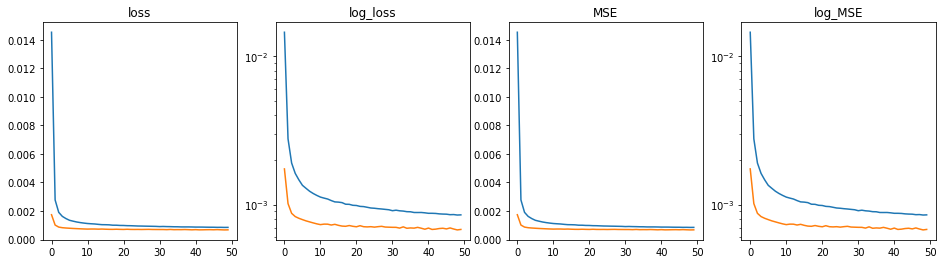

In [16]:
def plot_loss(his_fit_list):
    loss = np.median([fit_his.history['loss'] for fit_his in his_fit_list], axis=0)
    val_loss = np.median([fit_his.history['val_loss'] for fit_his in his_fit_list], axis=0)
    mse = np.median([fit_his.history['mean_squared_error'] for fit_his in his_fit_list], axis=0)
    val_mse = np.median([fit_his.history['val_mean_squared_error'] for fit_his in his_fit_list], axis=0)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))     
    axes[0].plot(loss)
    axes[0].plot(val_loss)
    axes[0].set_title('loss')

    axes[1].plot(loss)
    axes[1].plot(val_loss)
    axes[1].set_title('log_loss')
    axes[1].set_yscale('log')

    axes[2].plot(mse)
    axes[2].plot(val_mse)
    axes[2].set_title('MSE')
    
    axes[3].plot(mse)
    axes[3].plot(val_mse)
    axes[3].set_title('log_MSE')
    axes[3].set_yscale('log')
    
plot_loss(his_fit_list)    

## Save result

In [17]:
def save_to_submit(int_inf=False, linear_fit=False):
    X_inf, y_inf, _ = get_xy_inf(list_df, n_his=n_his, n_pred=n_pred_days)
    inf_all = inference(X_inf, y_inf, n_inf_days, model_list, int_inf=int_inf, linear_fit=linear_fit)[:,id_IL]
    # (n_region, n_pred)
    inf_all = np.reshape(inf_all, (n_inf_days,-1)).T
    dates = pd.date_range('2120-06-30', periods=n_inf_days).strftime('%Y%m%d')
    pred_list = []
    for col, inf in zip(cols, inf_all):
        city = [col.split('_')[0]]*n_inf_days
        region = [col.split('_')[1]]*n_inf_days
        inf = inv_log_df(inf, sc_inf, max_inf)
        pred_list += [list(_z) for _z in zip(city, region, dates, inf)]
    
    df_pred = pd.DataFrame(np.array(pred_list))
    df_pred.to_csv('outputs/submission.csv', header=False, index=False)
    
save_to_submit(int_inf=False, linear_fit=True)